In [ ]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import regionmask
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def train_flood_model_Shimla(
    data_folder,
    shapefile_path,
    flood_dates,
    model_type="xgb",
    district_name="Shimla",
    features=["d2m", "t2m", "swvl1", "swvl2", "swvl3", "ssro", "sro", "tp"],
    save_prefix="flood_model_Shimla",
    test_size=0.2,
    random_state=42
):
    
    print("📍 Loading shapefile and creating region mask...")
    hp_shp = gpd.read_file(shapefile_path)
    hp_shp = hp_shp[hp_shp["NAME_1"] == "Himachal Pradesh"].to_crs(4326)
    hp_shp = hp_shp.dissolve(by="NAME_2").reset_index()

    districts = regionmask.Regions(
        outlines=hp_shp.geometry.values,
        names=hp_shp["NAME_2"].values,
        abbrevs=hp_shp["NAME_2"].values
    )

    print("📂 Extracting daily data for Shimla district...")
    all_files = sorted([os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".nc")])

    Shimla_data = []

    for file in all_files:
        ds = xr.open_dataset(file)


        if "valid_time" in ds.dims:
            ds = ds.rename({"valid_time": "time"})


        mask = districts.mask(ds.longitude, ds.latitude)
        district_idx = np.where(np.array(districts.names) == district_name)[0][0]
        district_mask = (mask == district_idx)


        lon2d, lat2d = np.meshgrid(ds.longitude, ds.latitude)
        weights_2d = np.cos(np.deg2rad(lat2d))
        weights_xr = xr.DataArray(weights_2d, coords={"latitude": ds.latitude, "longitude": ds.longitude}, dims=["latitude", "longitude"])

        ds_masked = ds.where(district_mask)
        weighted_sum = (ds_masked * weights_xr).sum(dim=["latitude", "longitude"])
        total_weight = weights_xr.where(district_mask).sum(dim=["latitude", "longitude"])
        weighted_avg = weighted_sum / total_weight

        Shimla_data.append(weighted_avg)


    district_ts = xr.concat(Shimla_data, dim="time").sortby("time")

 
    df = district_ts.to_dataframe().reset_index()
    print(f"✅ Dataset created for {district_name} with shape {df.shape}")


    flood_dates = pd.to_datetime(flood_dates)
    df["label"] = pd.to_datetime(df["time"]).isin(flood_dates).astype(int)

 
    X = np.nan_to_num(df[features].values)
    y = df["label"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    if model_type == "xgb":
        from xgboost import XGBClassifier
        model = XGBClassifier(
            n_estimators=300, max_depth=4, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
            random_state=random_state
        )

    elif model_type == "rf":
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(
            n_estimators=200, max_depth=6,
            random_state=random_state
        )

    elif model_type == "svm":
        from sklearn.svm import SVC
        model = SVC(
            probability=True, kernel="rbf",
            C=1.0, gamma="scale", random_state=random_state
        )

    elif model_type == "lr":
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(
            max_iter=1000, solver="lbfgs", random_state=random_state
        )

    elif model_type == "knn":
        from sklearn.neighbors import KNeighborsClassifier
        model = KNeighborsClassifier(
            n_neighbors=7, weights="distance", metric="minkowski"
        )

    elif model_type == "dt":
        from sklearn.tree import DecisionTreeClassifier
        model = DecisionTreeClassifier(
            max_depth=6, criterion="gini", random_state=random_state
        )

    elif model_type == "ada":
        from sklearn.ensemble import AdaBoostClassifier
        model = AdaBoostClassifier(
            n_estimators=200, learning_rate=0.05, random_state=random_state
        )

    elif model_type == "gb":
        from sklearn.ensemble import GradientBoostingClassifier
        model = GradientBoostingClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=3, random_state=random_state
        )

    elif model_type == "mlp":
        from sklearn.neural_network import MLPClassifier
        model = MLPClassifier(
            hidden_layer_sizes=(64, 32), activation="relu",
            solver="adam", learning_rate_init=0.001,
            max_iter=500, random_state=random_state
        )

    else:
        raise ValueError(
            "model_type must be one of: 'xgb', 'rf', 'svm', 'lr', 'knn', 'dt', 'ada', 'gb', 'mlp', 'lgbm'"
        )

    print(f"🚀 Training model: {model_type.upper()} ...")
    model.fit(X_train_scaled, y_train)


 
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"✅ Model: {model_type.upper()} | Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")


    joblib.dump(model, f"{save_prefix}_{model_type}.pkl")
    joblib.dump(scaler, f"{save_prefix}_scaler.pkl")

    print(f"💾 Model saved as {save_prefix}_{model_type}.pkl")

    return model, scaler, {"accuracy": acc, "roc_auc": auc}, df



def predict_flood_probability(model_path, scaler_path, input_features):
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    x = np.array(input_features).reshape(1, -1)
    x_scaled = scaler.transform(x)
    return float(model.predict_proba(x_scaled)[0, 1])


In [6]:
flood_dates =['2022-05-28', 
                 '2022-05-29', 
                 '2022-05-30', 
                 '2022-06-28', 
                 '2022-06-29', '2022-06-30', '2022-07-01', 
                 '2022-07-05', '2022-07-06', '2022-07-07', '2022-08-10', '2022-08-11', 
                 '2022-08-12', '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21', '2023-06-23', 
                 '2023-06-24', '2023-06-25', '2023-06-26', '2023-07-08', '2023-07-09', '2023-07-10', 
                 '2023-07-11', '2023-07-12', '2023-07-17', '2023-07-18', '2023-07-19', '2023-07-21', 
                 '2023-07-22', '2023-07-23', '2023-08-13', '2023-08-14', '2023-08-15', '2023-08-16', 
                 '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25']


for m in ["xgb", "rf", "svm", "lr", "mlp"]:
    model, scaler, metrics, _ = train_flood_model_Shimla(
        data_folder="/Users/mayankgoel/Desktop/Stat/data_daily",
        shapefile_path="/Users/mayankgoel/Desktop/Stat/Stat_project/gadm41_IND_2.shp",
        flood_dates=flood_dates,
        model_type=m
    )



📍 Loading shapefile and creating region mask...
📂 Extracting daily data for Shimla district...
✅ Dataset created for Shimla with shape (184, 10)
🚀 Training model: XGB ...
✅ Model: XGB | Accuracy: 0.919 | ROC-AUC: 0.976
💾 Model saved as flood_model_Shimla_xgb.pkl
📍 Loading shapefile and creating region mask...
📂 Extracting daily data for Shimla district...
✅ Dataset created for Shimla with shape (184, 10)
🚀 Training model: RF ...
✅ Model: RF | Accuracy: 0.892 | ROC-AUC: 0.976
💾 Model saved as flood_model_Shimla_rf.pkl
📍 Loading shapefile and creating region mask...
📂 Extracting daily data for Shimla district...
✅ Dataset created for Shimla with shape (184, 10)
🚀 Training model: SVM ...
✅ Model: SVM | Accuracy: 0.865 | ROC-AUC: 0.710
💾 Model saved as flood_model_Shimla_svm.pkl
📍 Loading shapefile and creating region mask...
📂 Extracting daily data for Shimla district...
✅ Dataset created for Shimla with shape (184, 10)
🚀 Training model: LR ...
✅ Model: LR | Accuracy: 0.892 | ROC-AUC: 0.9

/Users/mayankgoel/Desktop/Stat/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
def extract_shimla_features_from_nc(nc_path, date_time):

    ds = xr.open_dataset(nc_path)
    if "valid_time" in ds.dims:
        ds = ds.rename({"valid_time": "time"})


    hp_shp = gpd.read_file("/Users/mayankgoel/Desktop/Stat/Stat_project/gadm41_IND_2.shp")
    hp_shp = hp_shp[hp_shp["NAME_1"] == "Himachal Pradesh"].to_crs(4326)
    hp_shp = hp_shp.dissolve(by="NAME_2").reset_index()

    districts = regionmask.Regions(
        outlines=hp_shp.geometry.values,
        names=hp_shp["NAME_2"].values,
        abbrevs=hp_shp["NAME_2"].values
    )

    mask = districts.mask(ds.longitude, ds.latitude)
    district_num = np.where(np.array(districts.names) == "Shimla")[0][0]
    district_mask = (mask == district_num)


    lon_2d, lat_2d = np.meshgrid(ds.longitude, ds.latitude)
    weights_2d = np.cos(np.deg2rad(lat_2d))
    weights_xr = xr.DataArray(
        weights_2d,
        coords={'latitude': ds.latitude, 'longitude': ds.longitude},
        dims=['latitude', 'longitude']
    )


    target_time = pd.to_datetime(date_time)
    if target_time not in pd.to_datetime(ds.time.values):
        print(f"⚠️ Date/time {target_time} not found in file {nc_path}")
        return None

    ds_sel = ds.sel(time=target_time)


    ds_masked = ds_sel.where(district_mask)
    weighted_sum = (ds_masked * weights_xr).sum(dim=["latitude", "longitude"])
    total_weight = weights_xr.where(district_mask).sum(dim=["latitude", "longitude"])
    weighted_avg = weighted_sum / total_weight


    features = ["d2m", "t2m", "swvl1", "swvl2", "swvl3", "ssro", "sro", "tp"]
    values = [float(weighted_avg[var].values) for var in features if var in weighted_avg]

    if len(values) != 8:
        print("⚠️ Missing variables in dataset; found:", len(values))
        return None

    return values


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

def compare_flood_models(
    data_path,
    model_base_path,
    month_str,
    start_day,
    end_day,
    model_types=None,
    feature_extractor=None,
    predictor=None
):
    
    if model_types is None:
        model_types = ["xgb", "rf", "svm", "lr", "dt", "gb", "ada", "mlp"]

    if feature_extractor is None or predictor is None:
        raise ValueError("You must pass feature_extractor and predictor functions.")


    model_predictions = {}
    for model_name in model_types:
        model_file = os.path.join(model_base_path, f"flood_model_Shimla_{model_name}.pkl")
        scaler_file = os.path.join(model_base_path, f"flood_model_Shimla_scaler.pkl")

        if not os.path.exists(model_file):
            print(f"⚠️ Skipping {model_name}: model file not found.")
            continue

        print(f"🔮 Running predictions for model: {model_name.upper()}")

        preds = []
        dates = []

        for day in range(start_day, end_day + 1):
            date_str = f"{month_str}-{day:02d} 00:00:00"
            features = feature_extractor(data_path, date_str)
            prob = predictor(model_file, scaler_file, features)
            preds.append(prob)
            dates.append(pd.to_datetime(date_str))

        model_predictions[model_name] = pd.Series(preds, index=dates)


    plt.figure(figsize=(12, 6))
    for name, preds in model_predictions.items():
        plt.plot(preds.index, preds.values, label=name.upper())

    plt.title(f"Flood Probability Predictions — {month_str}")
    plt.xlabel("Date")
    plt.ylabel("Flood Probability")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Models")
    plt.tight_layout()
    plt.show()

    n_models = len(model_predictions)
    if n_models == 0:
        print("❌ No models available to plot.")
        return model_predictions

    fig, axes = plt.subplots(n_models, 1, figsize=(12, 3 * n_models), sharex=True)
    if n_models == 1:
        axes = [axes]

    for ax, (name, preds) in zip(axes, model_predictions.items()):
        ax.plot(preds.index, preds.values, marker="o", label=name.upper())
        ax.set_title(f"{name.upper()} Flood Probability")
        ax.set_ylabel("Probability")
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend()

    axes[-1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()

    return model_predictions


🔮 Running predictions for model: XGB
🔮 Running predictions for model: RF
🔮 Running predictions for model: SVM
🔮 Running predictions for model: LR
⚠️ Skipping dt: model file not found.
⚠️ Skipping gb: model file not found.
⚠️ Skipping ada: model file not found.
🔮 Running predictions for model: MLP


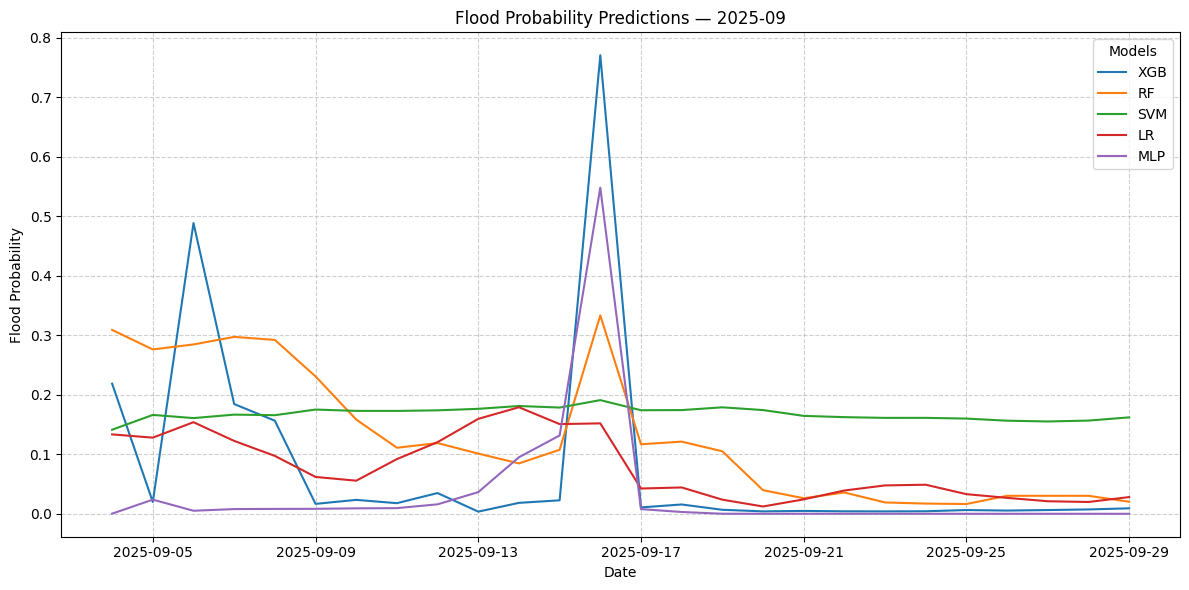

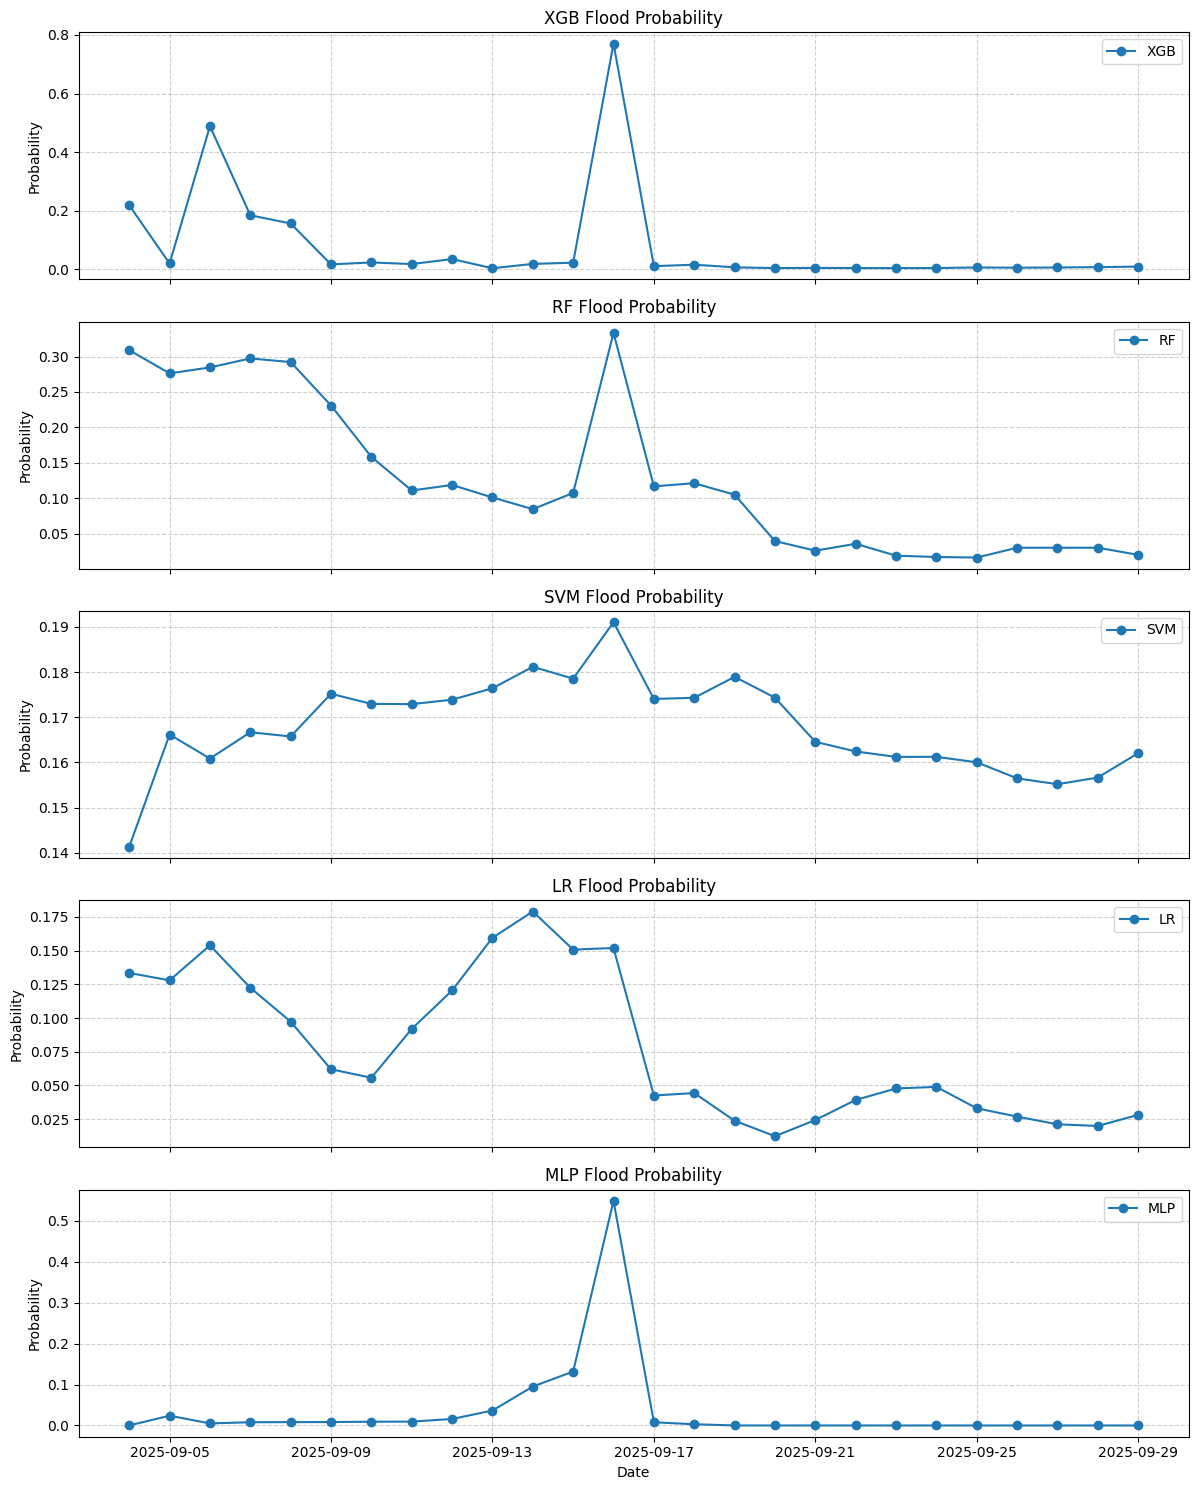

In [39]:
model_predictions = compare_flood_models(
    data_path="/Users/mayankgoel/Desktop/Stat/data_daily_sample/2025_09_daily.nc",
    model_base_path="/Users/mayankgoel/Desktop/Stat/Model_district",
    month_str="2025-09",
    start_day=4,
    end_day=29,
    feature_extractor=extract_shimla_features_from_nc,
    predictor=predict_flood_probability
)


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_flood_probability_single_model(
    data_path,
    model_base_path,
    month_str,
    start_day,
    end_day,
    model_name,
    threshold,
    district_name,
    feature_extractor,
    predictor,
    figsize=(12, 6)   
):
   
    model_file = os.path.join(model_base_path, f"flood_model_{district_name.lower()}_{model_name}.pkl")
    scaler_file = os.path.join(model_base_path, f"flood_model_{district_name.lower()}_scaler.pkl")

    if not os.path.exists(model_file):
        print(f"❌ Model file not found: {model_file}")
        return
    if not os.path.exists(scaler_file):
        print(f"❌ Scaler file not found: {scaler_file}")
        return

    print(f"🔮 Running flood probability predictions for {district_name} — {model_name.upper()}")


    preds, dates = [], []
    for day in range(start_day, end_day + 1):
        date_str = f"{month_str}-{day:02d} 00:00:00"
        features = feature_extractor(data_path, date_str)
        prob = predictor(model_file, scaler_file, features)
        preds.append(prob)
        dates.append(pd.to_datetime(date_str))

    probs = pd.Series(preds, index=dates)


    plt.figure(figsize=figsize)  


    plt.axhspan(threshold, 1.0, color="red", alpha=0.1, label=f"High Risk Zone (>{threshold})")


    plt.axhline(y=threshold, color="red", linestyle="--", linewidth=2)


    plt.plot(probs.index, probs.values, marker="o", linewidth=2, label="Flood Probability", color="steelblue")


    max_idx = probs.idxmax()
    max_val = probs.max()
    plt.scatter(max_idx, max_val, color="red", s=80, zorder=5, label=f"Max: {max_val:.2f} on {max_idx.date()}")
    plt.axvline(x=max_idx, color="red", linestyle="--", alpha=0.6)
    plt.text(
        max_idx, max_val + 0.03,
        f"{max_val:.2f}\n{max_idx.date()}",
        color="red",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=45, ha="right")


    plt.title(
        f"Flood Probability in {district_name} (Model: {model_name.upper()}) — "
        f"{pd.to_datetime(month_str).strftime('%B %Y')}",
        fontsize=14,
        fontweight="bold"
    )
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Predicted Flood Probability", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.ylim(0, 1)
    plt.legend(loc="upper right", fontsize=10)
    plt.tight_layout()
    plt.show()

    return probs


In [7]:
def predict_flood_probability(model_path, scaler_path, input_features):
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    x = np.array(input_features).reshape(1, -1)
    x_scaled = scaler.transform(x)
    return float(model.predict_proba(x_scaled)[0, 1])
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import regionmask
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

🔮 Running flood probability predictions for Shimla — XGB


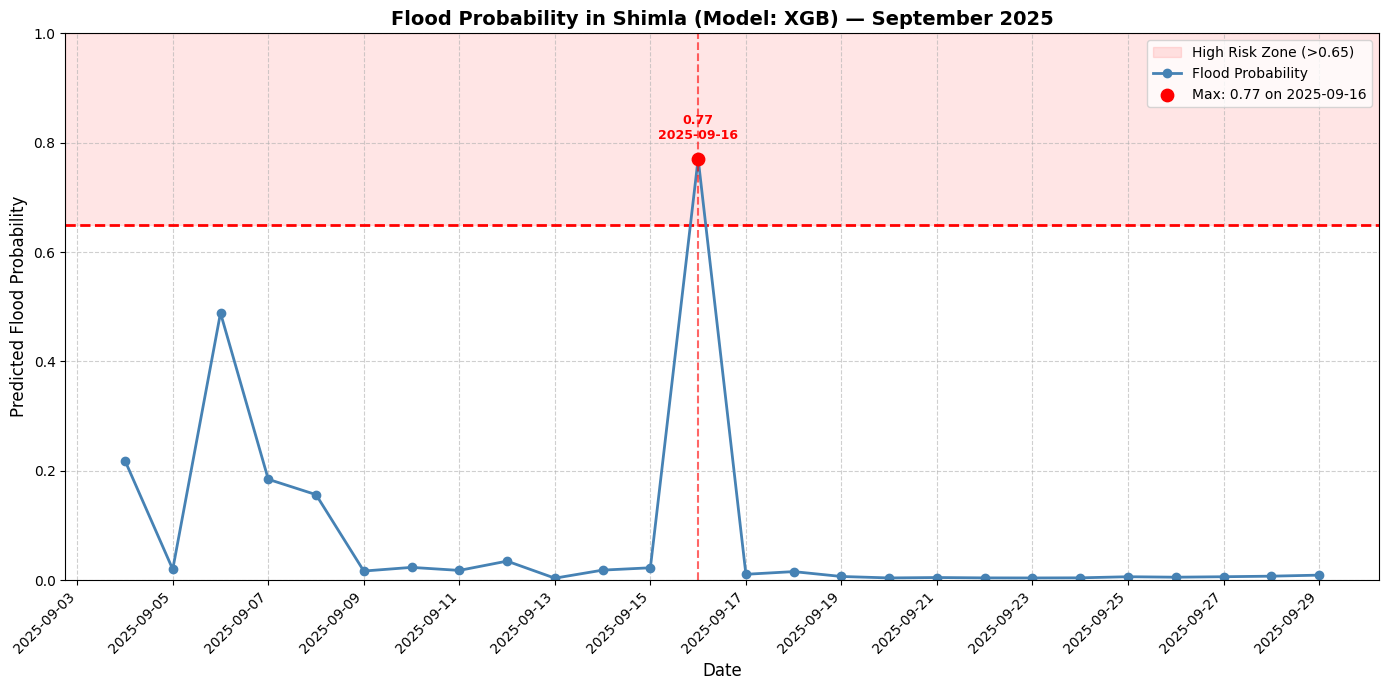

2025-09-04    0.218648
2025-09-05    0.019846
2025-09-06    0.488654
2025-09-07    0.184462
2025-09-08    0.156388
2025-09-09    0.016684
2025-09-10    0.023381
2025-09-11    0.017854
2025-09-12    0.034845
2025-09-13    0.003654
2025-09-14    0.018373
2025-09-15    0.022648
2025-09-16    0.770635
2025-09-17    0.010739
2025-09-18    0.015660
2025-09-19    0.006738
2025-09-20    0.004090
2025-09-21    0.004828
2025-09-22    0.004177
2025-09-23    0.004064
2025-09-24    0.004263
2025-09-25    0.006278
2025-09-26    0.005432
2025-09-27    0.006278
2025-09-28    0.007310
2025-09-29    0.009208
dtype: float64

In [10]:
plot_flood_probability_single_model(
    data_path="/Users/mayankgoel/Desktop/Stat/data_daily_sample/2025_09_daily.nc",
    model_base_path="/Users/mayankgoel/Desktop/Stat/Model_district",
    month_str="2025-09",
    start_day=4,
    end_day=29,
    model_name="xgb",
    threshold=0.65,
    district_name="Shimla",
    feature_extractor=extract_shimla_features_from_nc,
    predictor=predict_flood_probability,
    figsize=(14, 7) 
)
